## Imports and List Amino Acid Codes

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np
from Bio.PDB import *
import os
import warnings
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

amino3CodesStr = 'alaargasnaspcysgluglnglyhisileleulysmetpheproserthrtrptyrval'
amino3Codes = [amino3CodesStr[x:x+3].upper() for x in range(0, len(amino3CodesStr), 3)]
amino3Codes = list(sorted(amino3Codes))
print(amino3Codes, len(amino3Codes)) 

['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] 20


## General Protein Frequency Calculation

In [4]:
parser = PDBParser()
AInteractionList, BInteractionList = {}, {}
AfreqChart, BfreqChart = np.empty((20, 20)), np.empty((20, 20))
AfreqChart.fill(np.nan)
BfreqChart.fill(np.nan)

for i in range(len(amino3Codes)):
    for j in range(i, len(amino3Codes)):
        combinationName = amino3Codes[i] + " " + amino3Codes[j]
        AInteractionList[combinationName] = 0
        BInteractionList[combinationName] = 0
with open("generalData\pdb_4960list.txt", "r") as f:
    for l in f.readlines():
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] != chainNames[1]:
            protein = parser.get_structure(pdbName[:-4], "cleanGeneral/"+pdbName)
            chains = list(list(protein.get_models())[0].get_chains())
            chainL, chainH = [], []
            for x in chains: 
                if x.id == chainNames[0]:
                    chainL = list(x.get_residues())
                if x.id == chainNames[1]:
                    chainH = list(x.get_residues())
            resA, resB = chainL, chainH
            AAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resA if x.get_resname() in amino3Codes]))
            BAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resB if x.get_resname() in amino3Codes]))
            
            if len(BAtomList) == 0 or len(AAtomList)==0:
                continue
            NBSearch, NBSearch3 = NeighborSearch(AAtomList), NeighborSearch(BAtomList)
            InteractingAList = []
            for res in resB:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        InteractingAList.append(res)
                        break
            InteractingBList = []
            for res in resA:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch3.search(centerPos, 5, 'R')) > 0:
                        InteractingBList.append(res)
                        break

            ### Count intra-Ag interactions -> dict
            atms = [r.get_atoms() for r in InteractingAList if r.get_resname() in amino3Codes]
            atms2 = [r.get_atoms() for r in InteractingBList if r.get_resname() in amino3Codes]

            if (len(atms) > 0 and len(atms2) > 0):
                NBSearch = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
                AInteractions = NBSearch.search_all(5, level='R')
                for (r1, r2) in AInteractions:
                    combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                    AInteractionList[combinationName] += 1
                
                NBSearch2 = NeighborSearch(list(chain.from_iterable(atms2))) # Count interactions using neighbor search
                BInteractions = NBSearch2.search_all(5, level='R')
                for (r1, r2) in BInteractions:
                    combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                    BInteractionList[combinationName] += 1
for r in range(len(amino3Codes)):
    for c in range(r, len(amino3Codes)):
        fst, snd = amino3Codes[r], amino3Codes[c]
        combinationName = fst + " " + snd
        countA = AInteractionList[combinationName]
        countB = BInteractionList[combinationName]
        AfreqChart[r, c] = countA
        BfreqChart[r, c] = countB

c:\Python310\lib\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE1) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
c:\Python310\lib\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE2) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


In [5]:
aCounter = Counter(AInteractionList)
bCounter = Counter(BInteractionList)
aCounter.update(bCounter)
combinedDict = dict(aCounter)
ABfreqChart = np.empty((20, 20))
ABfreqChart.fill(np.nan)
for r in range(len(amino3Codes)):
    for c in range(r, len(amino3Codes)):
        fst, snd = amino3Codes[r], amino3Codes[c]
        combinationName = fst + " " + snd
        count = combinedDict[combinationName]
        ABfreqChart[r, c] = count

## Display General Protein Heat Maps

Text(0.5, 1.0, 'Chain A Total Internal Residue Interaction Combination Frequency of General Protein Dataset')

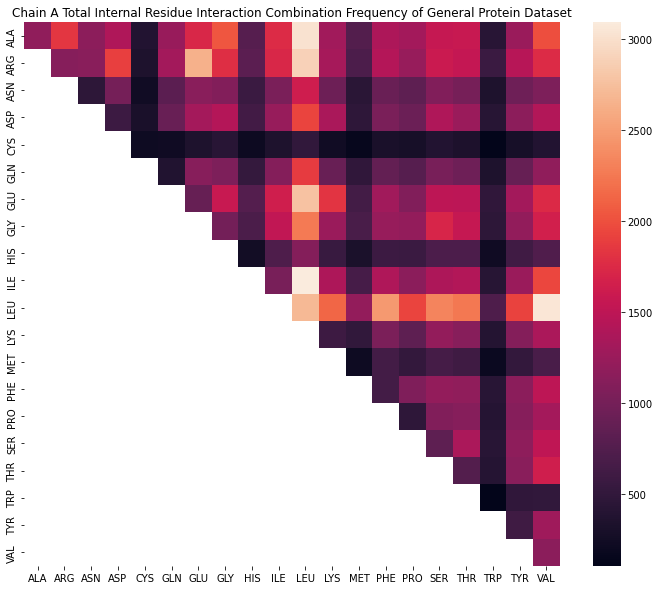

In [6]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(AfreqChart)
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
plt.title("Chain A Total Internal Residue Interaction Combination Frequency of General Protein Dataset")

Text(0.5, 1.0, 'Chain B Total Internal Residue Interaction Combination Frequency of General Protein Dataset')

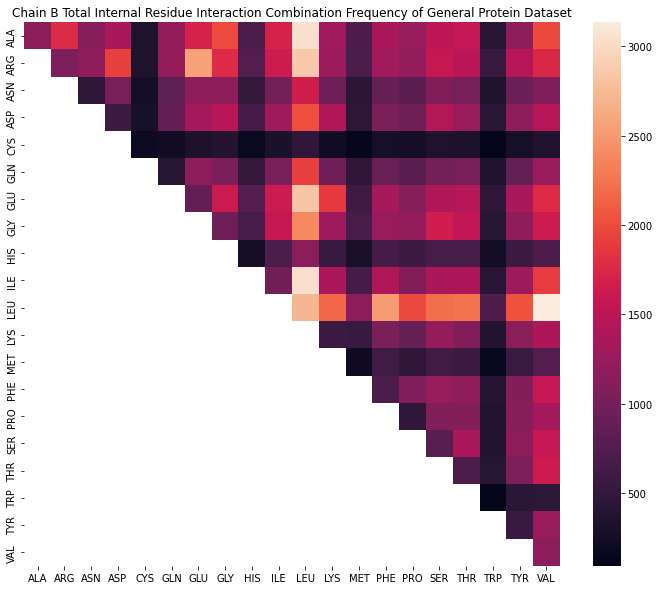

In [7]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(BfreqChart)
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
plt.title("Chain B Total Internal Residue Interaction Combination Frequency of General Protein Dataset")

Text(0.5, 1.0, 'Combined Total Internal Residue Interaction Combination Frequency of General Protein Dataset')

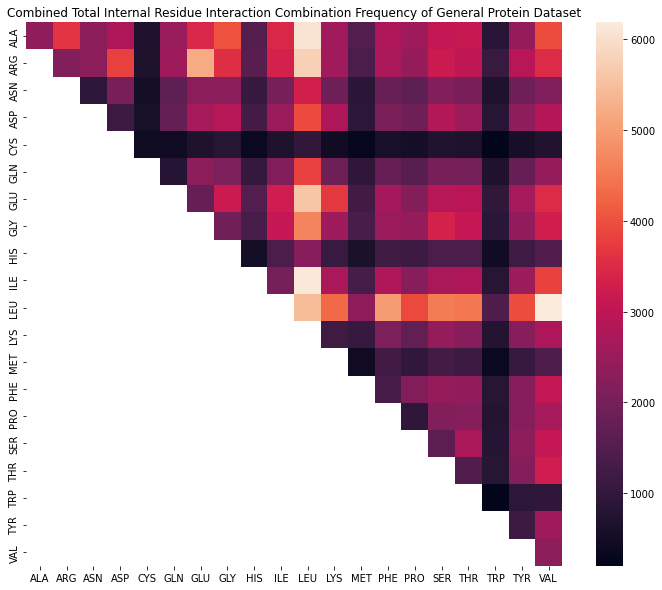

In [8]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(ABfreqChart)
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
plt.title("Combined Total Internal Residue Interaction Combination Frequency of General Protein Dataset")

## Display General Protein Bar Graphs

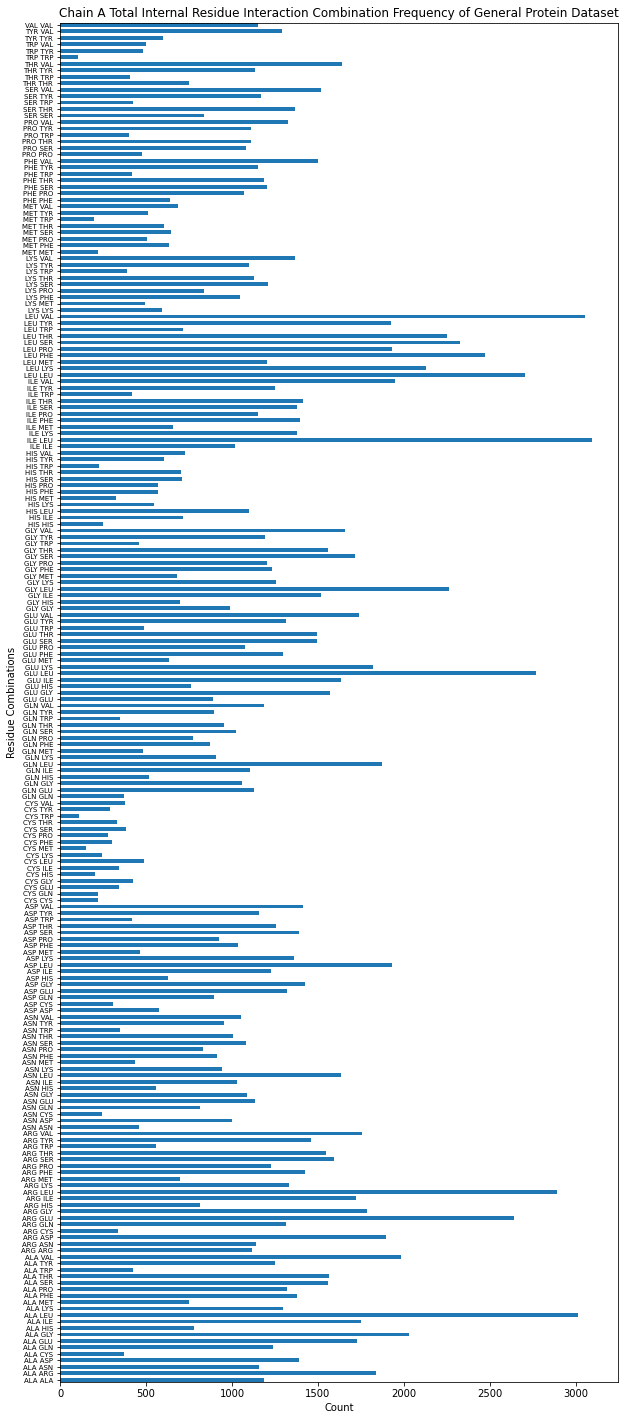

In [9]:
# Create bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 25))
ax.barh(*zip(*AInteractionList.items()), height=0.6)
ax.set_title("Chain A Total Internal Residue Interaction Combination Frequency of General Protein Dataset")
ax.set_xlabel("Count")
ax.set_ylabel("Residue Combinations")
ax.margins(y=0)
ax.tick_params(axis='y', labelsize=7) 
plt.show()

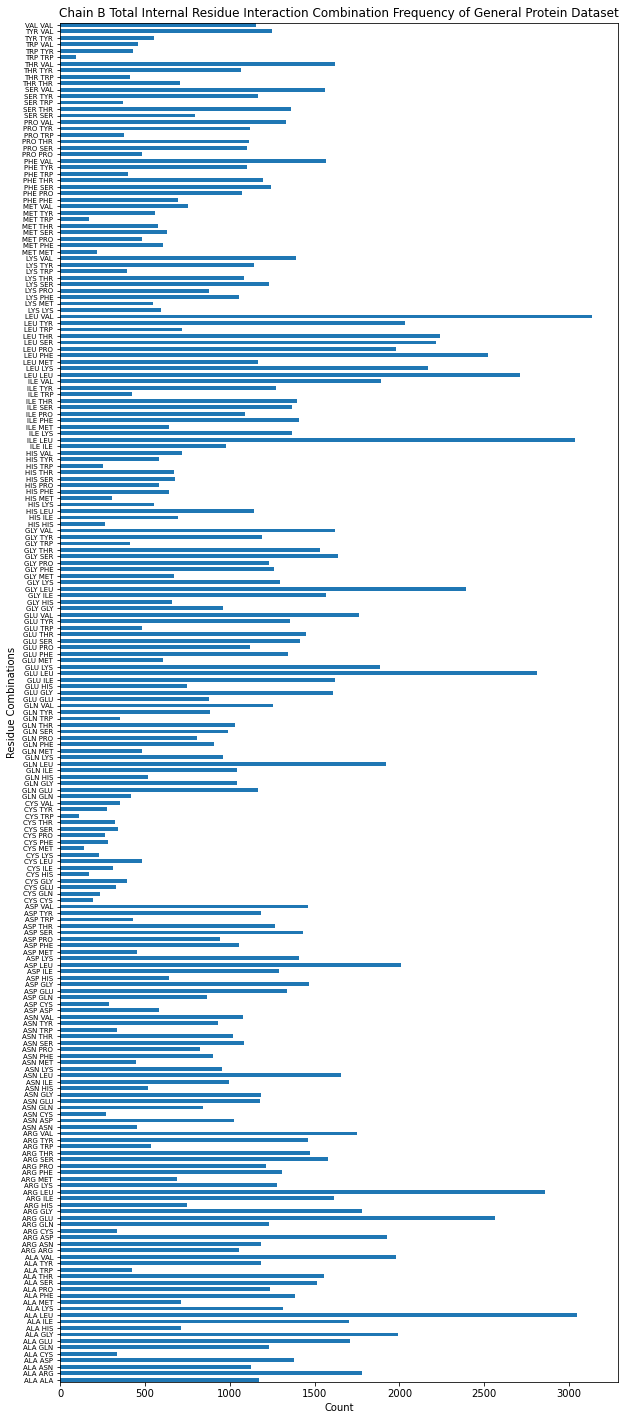

In [10]:
# Create bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 25))
ax.barh(*zip(*BInteractionList.items()), height=0.6)
ax.set_title("Chain B Total Internal Residue Interaction Combination Frequency of General Protein Dataset")
ax.set_xlabel("Count")
ax.set_ylabel("Residue Combinations")
ax.margins(y=0)
ax.tick_params(axis='y', labelsize=7) 
plt.show()

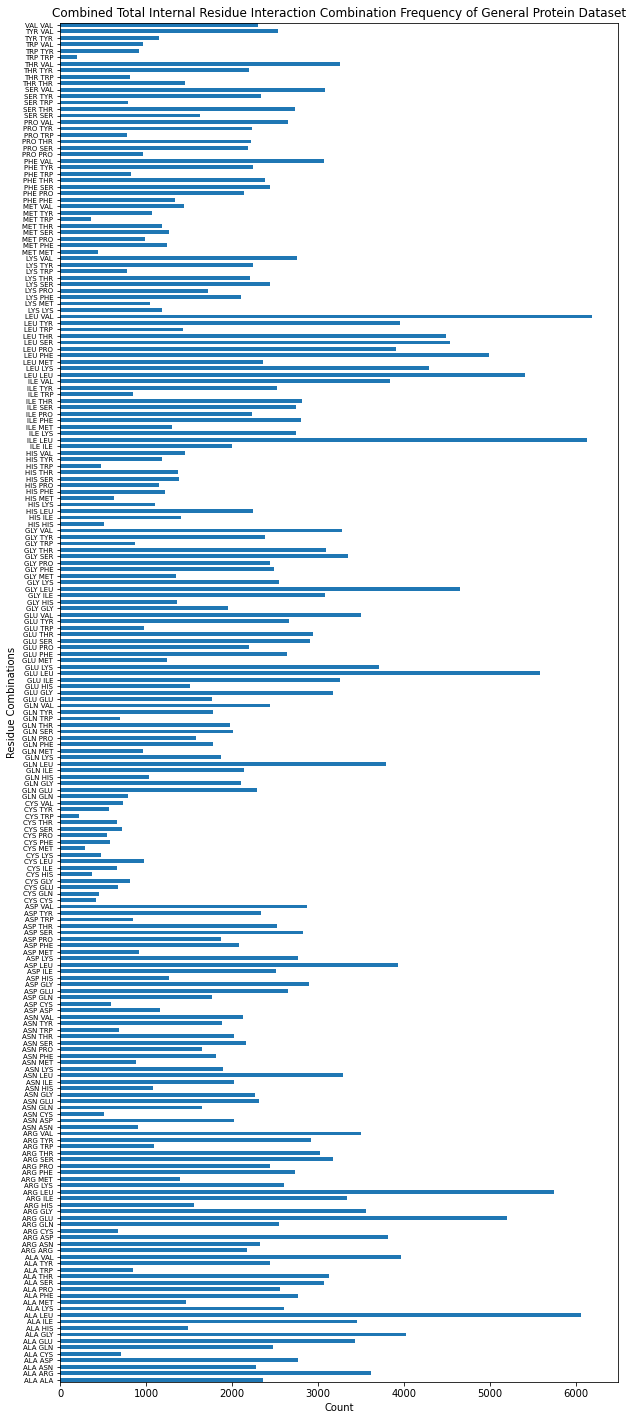

In [11]:
# Create bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 25))
ax.barh(*zip(*combinedDict.items()), height=0.6)
ax.set_title("Combined Total Internal Residue Interaction Combination Frequency of General Protein Dataset")
ax.set_xlabel("Count")
ax.set_ylabel("Residue Combinations")
ax.margins(y=0)
ax.tick_params(axis='y', labelsize=7) 
plt.show()

## Antigen Antibody Combination Frequency
### Antigen

In [13]:
# Initialize empty intra-antigen interaction list
AgInteractionList = {}
AgfreqChart = np.empty((20, 20))
AgfreqChart.fill(np.nan)

for i in range(len(amino3Codes)):
    for j in range(i, len(amino3Codes)):
        combinationName = amino3Codes[i] + " " + amino3Codes[j]
        AgInteractionList[combinationName] = 0

parser = PDBParser()
for filename in os.listdir("cleanAbAgData"):
    InteractingAgList = []
    data = parser.get_structure(filename[:-4], "cleanAbAgData/"+filename)
    chains = list(list(data.get_models())[0].get_chains())
    chainL, chainH = [], []
    for x in chains: # for chain in chains
        if x.id == "L":
            chainL = list(x.get_residues())
        if x.id == "H":
            chainH = list(x.get_residues())
    chainsLH = chainL + chainH

    # Create atom list of Ab residues for searching later 
    AbAtomList = [list(x.get_atoms()) for x in chainsLH if x.get_resname() in amino3Codes]
    AbAtomList = list(chain.from_iterable(AbAtomList))
    NBSearch = NeighborSearch(AbAtomList)

    ### Gather Ag residues interacting with Ab 
    for x in chains:
        currRes = list(x.get_residues())
        if x.id != "L" and x.id != "H":
            for res in currRes:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        InteractingAgList.append(res)
                        break # break after a single atom from the residue interacts with Ab 

    ### Count intra-Ag interactions -> dict
    atms = [r.get_atoms() for r in InteractingAgList if r.get_resname() in amino3Codes]
    if len(atms) > 0:
        NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
        AgInteractions = NBSearch2.search_all(5, level='R')
        for (r1, r2) in AgInteractions:
            combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
            AgInteractionList[combinationName] += 1
        
for r in range(len(amino3Codes)):
    for c in range(r, len(amino3Codes)):
        fst, snd = amino3Codes[r], amino3Codes[c]
        combinationName = fst + " " + snd
        count = AgInteractionList[combinationName]
        AgfreqChart[r, c] = count

c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5079
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5080
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5081
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5082
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5083
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5084
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 

### Antibody

In [14]:
# Initialize empty intra-antibody interaction list
AbInteractionList = {}
AbfreqChart = np.empty((20, 20))
AbfreqChart.fill(np.nan)

for i in range(len(amino3Codes)):
    for j in range(i, len(amino3Codes)):
        combinationName = amino3Codes[i] + " " + amino3Codes[j]
        AbInteractionList[combinationName] = 0

ranges = [[27, 36], [48, 60], [91, 104]]
for filename in os.listdir("cleanAbAgData"):
    AbCDR = []
    data = parser.get_structure(filename[:-4], "cleanAbAgData/"+filename)
    chains = list(list(data.get_models())[0].get_chains())
    chainL, chainH = [], []
    for x in chains: # for chain in chains
        if x.id == "L":
            chainL = list(x.get_residues())
        if x.id == "H":
            chainH = list(x.get_residues())
    # Now the AbCDR region is contained inside the variable as a list of residues
    
    chainsLH = [chainL, chainH]
    for chainX in chainsLH:
        for r in ranges:
            fst, snd = r[0], r[1]
            AbCDR += chainX[fst-1: snd]

    # Count interactions using neighbor search
    atms = [r.get_atoms() for r in AbCDR if r.get_resname() in amino3Codes]
    if len(atms) > 0:
        NBSearch = NeighborSearch(list(chain.from_iterable(atms)))
        AbInteractions = NBSearch.search_all(5, level='R')
        for (r1, r2) in AbInteractions:
            combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
            AbInteractionList[combinationName] += 1
    
for r in range(len(amino3Codes)):
    for c in range(r, len(amino3Codes)):
        fst, snd = amino3Codes[r], amino3Codes[c]
        combinationName = fst + " " + snd
        count = AbInteractionList[combinationName]
        AbfreqChart[r, c] = count

c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5079
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5080
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5081
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5082
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5083
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5084
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 

#### Combine

In [15]:
agCounter = Counter(AgInteractionList)
abCounter = Counter(AbInteractionList)
agCounter.update(abCounter)
combinedDict2 = dict(agCounter)
AbAgHeatmap = np.empty((20, 20))
AbAgHeatmap.fill(np.nan)
for r in range(len(amino3Codes)):
    for c in range(r, len(amino3Codes)):
        fst, snd = amino3Codes[r], amino3Codes[c]
        combinationName = fst + " " + snd
        count = combinedDict2[combinationName]
        AbAgHeatmap[r, c] = count

## Display Bar Graphs

### Display Antigen

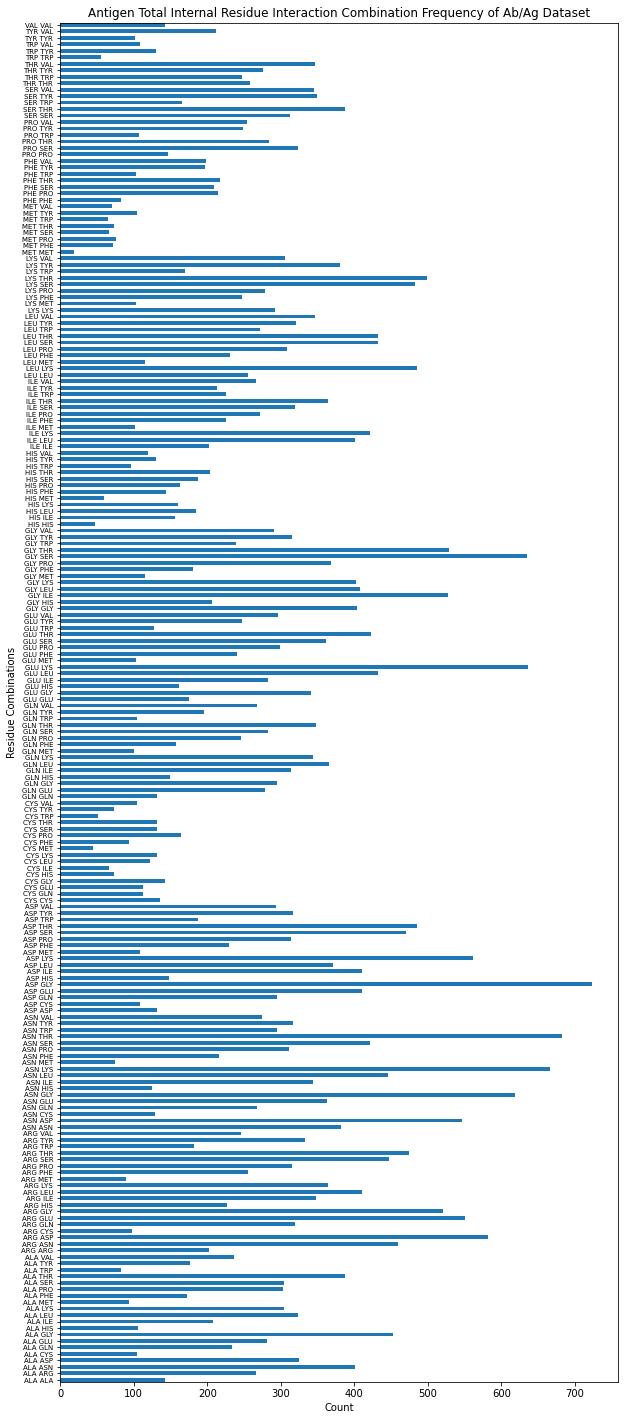

In [16]:
# Create bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 25))
ax.barh(*zip(*AgInteractionList.items()), height=0.6)
ax.set_title("Antigen Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset")
ax.set_xlabel("Count")
ax.set_ylabel("Residue Combinations")
ax.margins(y=0)
ax.tick_params(axis='y', labelsize=7) 
plt.show()

### Display Antibody

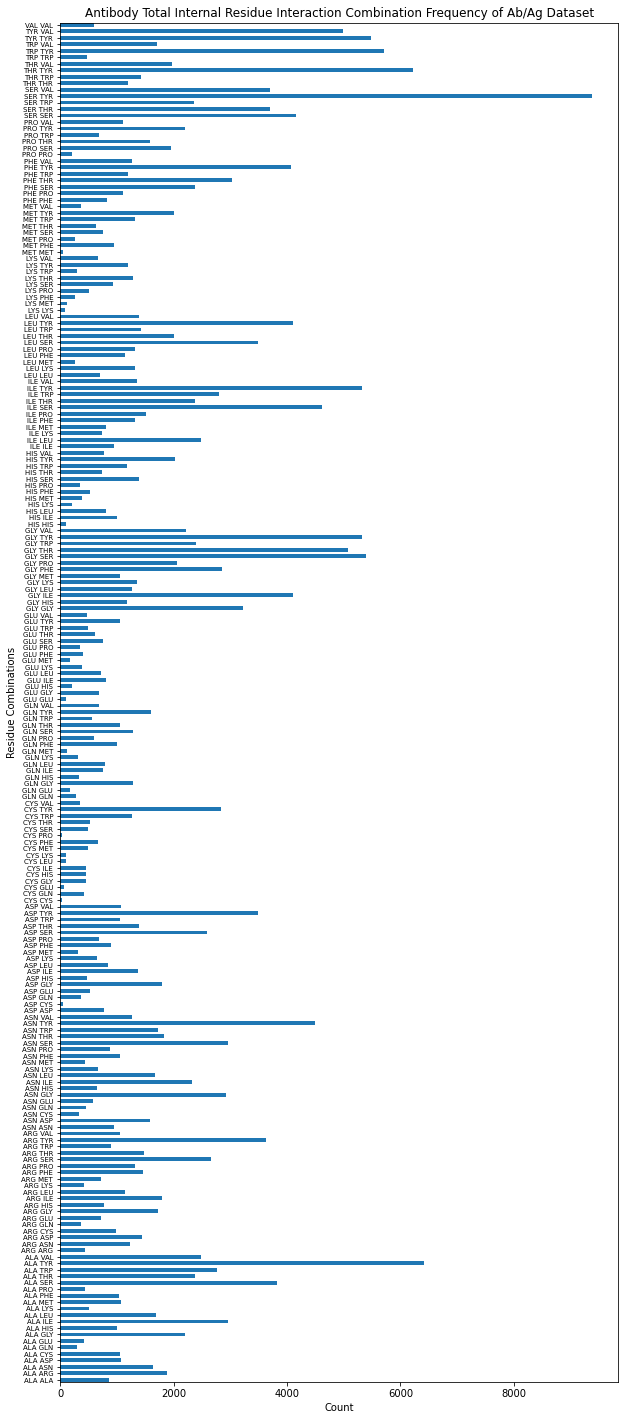

In [17]:
# Create bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 25))
ax.barh(*zip(*AbInteractionList.items()), height=0.6)
ax.set_title("Antibody Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset")
ax.set_xlabel("Count")
ax.set_ylabel("Residue Combinations")
ax.margins(y=0)
ax.tick_params(axis='y', labelsize=7) 
plt.show()

### Display Combined

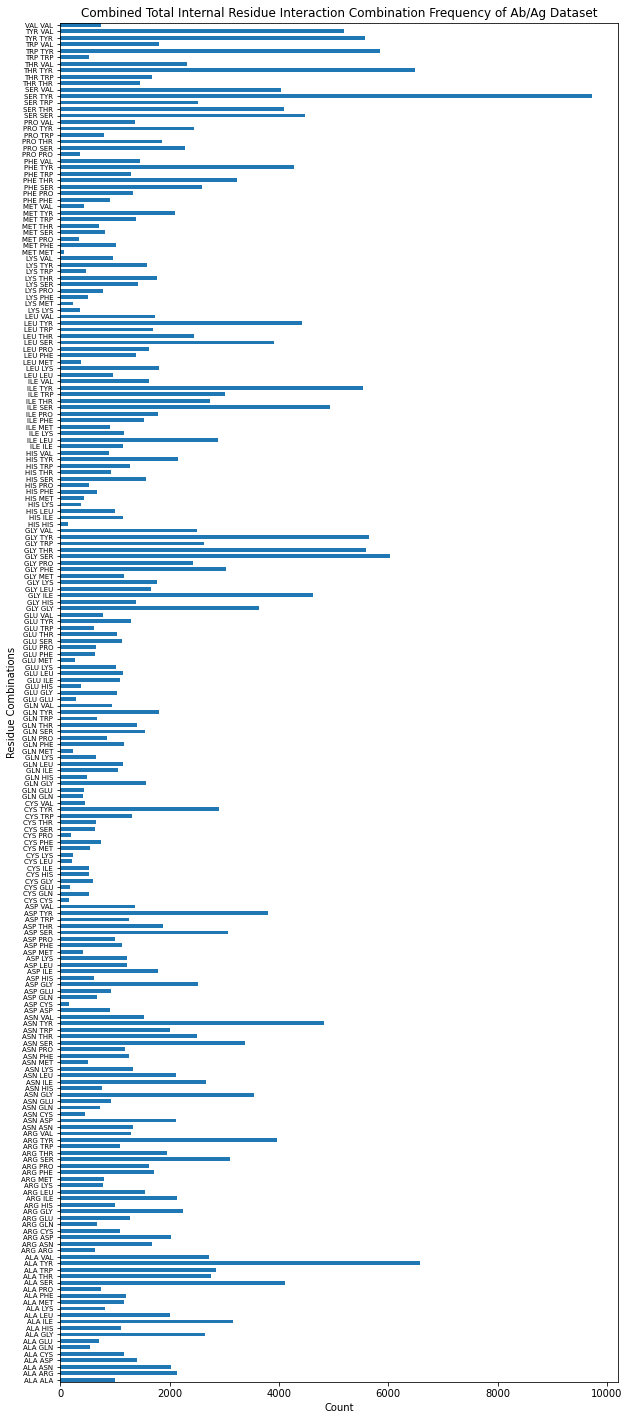

In [18]:
# Create bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 25))
ax.barh(*zip(*combinedDict2.items()), height=0.6)
ax.set_title("Combined Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset")
ax.set_xlabel("Count")
ax.set_ylabel("Residue Combinations")
ax.margins(y=0)
ax.tick_params(axis='y', labelsize=7) 
plt.show()

## Display Heatmaps for Ab/Ag Dataset

Text(0.5, 1.0, 'Antigen Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset')

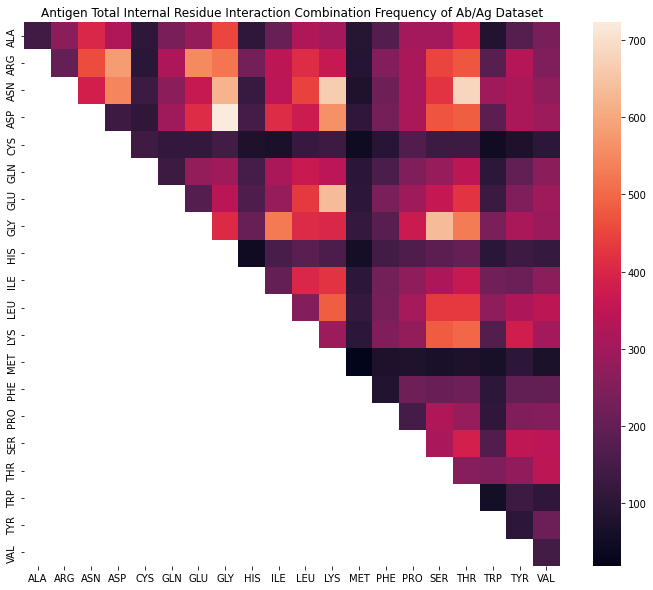

In [19]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(AgfreqChart)
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
ax.set_title("Antigen Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset") 

### Antibody

Text(0.5, 1.0, 'Antibody Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset')

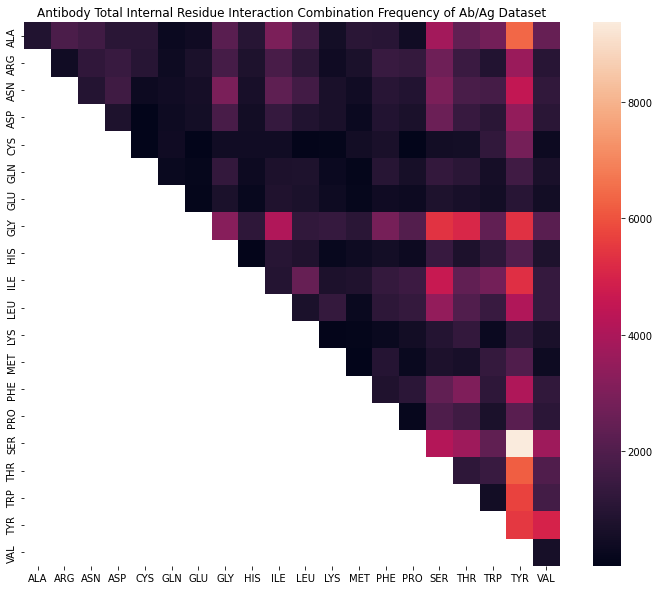

In [20]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(AbfreqChart)
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
plt.title("Antibody Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset")

Text(0.5, 1.0, 'Combined Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset')

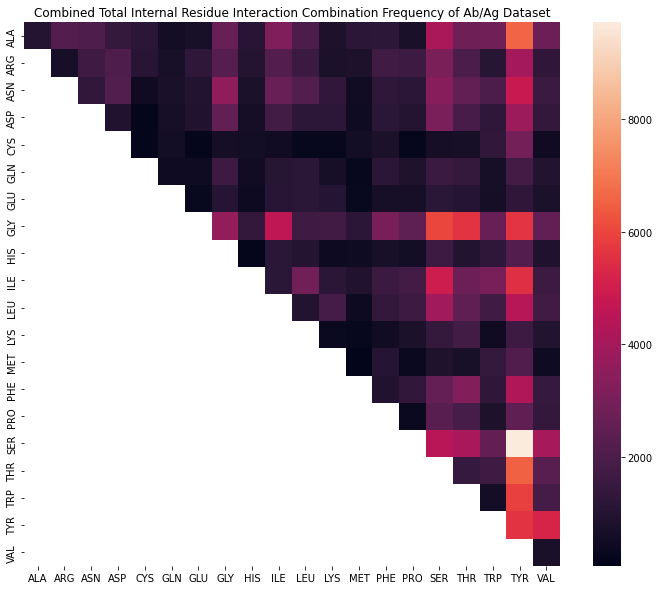

In [21]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(AbAgHeatmap)
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
plt.title("Combined Total Internal Residue Interaction Combination Frequency of Ab/Ag Dataset")

## Make Spreadsheet of Actual Numbers

In [22]:
df1 = pd.DataFrame.from_dict(AInteractionList, orient='index')
df2 = pd.DataFrame.from_dict(BInteractionList, orient='index')
df3 = pd.DataFrame.from_dict(combinedDict, orient='index')
df4 = pd.DataFrame.from_dict(AgInteractionList, orient='index')
df5 = pd.DataFrame.from_dict(AbInteractionList, orient='index')
df6 = pd.DataFrame.from_dict(combinedDict2, orient='index')
df = [df1, df2, df3, df4, df5, df6]
mergedDf = pd.concat(df, axis=1)
mergedDf.columns = ['ChainA', 'ChainB', 'CombinedGeneral', 'Ag', 'Ab', 'CombinedAbAg']
mergedDf.index.name = 'Interaction Residues'
mergedDf.to_csv("usefulOutputs/Merged_Interaction_Frequency.csv")